In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")

%load_ext pycodestyle_magic
%pycodestyle_on --ignore E501
%pycodestyle_off

time: 1.91 s (started: 2022-07-03 14:48:32 +00:00)


# Prepare data

In [2]:
stock_price_df = pd.read_csv("../../stock08_price.csv")

universe = list(stock_price_df.columns.values[1:])
universe.remove("SP500")
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))

pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
# display(stock_price_df)

150 445 295
time: 111 ms (started: 2022-07-03 14:48:34 +00:00)


In [3]:
def gen_unseen_data_corr(portfolio: list, ret_date: bool = False) -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = stock_price_df[portfolio[0]].rolling(window=100).corr(stock_price_df[portfolio[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    corr_series = tmp_corr[len(tmp_corr)-21:len(tmp_corr)]
    # tmp_corr = tmp_corr[:21]
    unseen_data_df = pd.DataFrame(corr_series).reset_index().drop(['Date'], axis=1).T
    if ret_date:
        return unseen_data_df, corr_series
    else:
        return unseen_data_df

time: 676 µs (started: 2022-07-03 14:48:35 +00:00)


# ARIMA model

In [ ]:
def arima_model(dataset: "pd.DataFrame", portfolio: list, overview: bool = False) -> ("np.array", "pd.DataFrame", str):
    model_110 = ARIMA(order=(1, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_330 = ARIMA(order=(3, 3, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)

    model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}

    tested_models = []
    arima_model = None
    find_arima_model = False
    residual = []
    for s in np.array(dataset):
        while not find_arima_model:
            try:
                for model_key in model_dict:
                    if model_key not in tested_models:
                        test_model = model_dict[model_key].fit(s)
                        if arima_model is None:
                            arima_model = test_model
                            arima_model_name = model_key
                        elif arima_model.aic() <= test_model.aic():
                            pass
                        else:
                            arima_model = test_model
                            arima_model_name = model_key
                    tested_models.append(model_key)

            except Exception:
                if len(model_dict)-1 != 0:
                    del model_dict[model_key]
                else:
                    print(f"fatal error, {portfolio} doesn't have appropriate arima model")
                    break
            else:
                model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
                tested_models.clear()
                find_arima_model = True

        arima_pred = list(arima_model.predict_in_sample())
        arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]
        arima_pred = np.clip(np.array(arima_pred), -1, 1)

        res = pd.Series(np.array(s) - arima_pred)
        residual.append(np.array(res)[:20])
        find_arima_model = False
    residual = pd.DataFrame(residual)

    if overview:
        plt.plot(arima_pred, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(res, label="res")
        plt.legend()
        plt.show()
        plt.close()

    return arima_pred, residual, arima_model_name

# LSTM

In [ ]:
class DoubleTanh(Activation):
    def __init__(self, activation, **kwargs):
        super(DoubleTanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'


def double_tanh(x):
    return (K.tanh(x) * 2)


get_custom_objects().update({'double_tanh': DoubleTanh(double_tanh)})

filepath = './stock_correlation_prediction/models/hybrid_LSTM/epoch262.h5'
custom_objects = {"Double_Tanh": DoubleTanh}
with keras.utils.custom_object_scope(custom_objects):
    lstm_model = load_model(filepath)

# Hybrid model

In [4]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).mean()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p
    
    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult.plot()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

time: 940 µs (started: 2022-07-03 14:48:41 +00:00)


In [ ]:
res_list = []
count = 0
for portfolio in tqdm(combinations(portfolio_other, 2)):
    # unseen_data_corr = gen_unseen_data_corr(portfolio)
    unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(portfolio, ret_date=True)
    arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df, portfolio)
    unseen_res = residual.values.reshape((-1, 20, 1))
    lstm_pred = lstm_model.predict(unseen_res)
    season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_series)
    portfolio_res_dic = {"portfolio": f"{portfolio[0]} & {portfolio[1]}",
                         "corr_ser_mean": unseen_data_corr_series.mean(),
                         "corr_ser_std": unseen_data_corr_series.std(),
                         "corr_season_period": season_period,
                         "corr_stl_resid": stl_resid,
                         "corr_stl_trend_std": stl_trend_std,
                         "corr_trend_coef": coef_reg_trend,
                         "arima_model": arima_model_name,
                         "lstm_pred": lstm_pred[0][0],
                         "arima_pred": arima_pred[-1],
                         "hybrid_model_pred": arima_pred[-1]+lstm_pred[0][0],
                         "ground_truth": unseen_data_corr_df.iloc[0, -1],
                         "arima_err": unseen_data_corr_df.iloc[0, -1] - arima_pred[-1],
                         "lstm_compen_err": arima_pred[-1] - lstm_pred[0][0],
                         "error": (unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])),
                         "absolute_err": math.copysign((unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])), 1), 
                         "lstm_compensation_dir": np.sign(unseen_data_corr_df.iloc[0, -1] - arima_pred[-1])*np.sign(lstm_pred[0][0])}

    res_list.append(portfolio_res_dic)
    #count = count + 1
    #if count > 10:
    #    break

In [ ]:
res_df = pd.DataFrame(res_list)
res_df.to_csv("./stock_correlation_prediction/use_hybrid_model/295stocks_res.csv", index=False)

# Display results

In [ ]:
res_df = pd.read_csv("./stock_correlation_prediction/use_hybrid_model/295stocks_res.csv")
display(res_df)

In [ ]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}")

In [ ]:
def stock_analysis(target_df: pd.core.frame.DataFrame):
    target_df['std_of_price_p1'] = target_df.apply(lambda row:stock_price_df[row['portfolio'].split(" & ")[0]].std(), axis=1)


def plot_exploration(target_df: pd.core.frame.DataFrame) -> None:
    target_df['arima_err'] = target_df['ground_truth'] - target_df['arima_pred']
    target_df['lstm_compen_err'] = target_df['arima_err'] - target_df['lstm_pred']
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s7 = axes[3, 1]
    s7.set_title("LSTM_model compensation Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_compen_err"], ax=s7)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    plt.tight_layout()
    plt.savefig("./stock_correlation_prediction/first21_hybrid_prediction_analysis.png")
    plt.show()
    plt.close()

In [ ]:
display(res_df)
cal_attr_of_df(res_df)
display(res_df)

In [ ]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(['RCL', 'CXO'], ret_date=True)
np.mean(unseen_data_corr_series), np.std(unseen_data_corr_series, ddof=1), st.sem(unseen_data_corr_series), st.sem(unseen_data_corr_series)*21**0.5

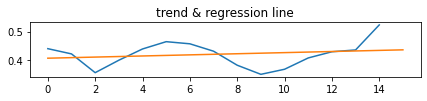

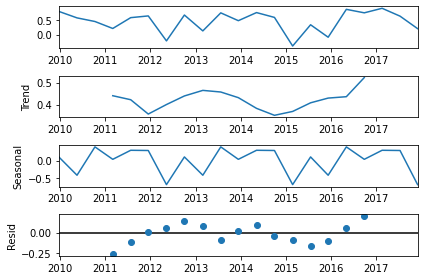

(7, 0.10261557799973116, 0.0019387537834567074, 0.045141224395148685)

time: 489 ms (started: 2022-07-03 14:49:13 +00:00)


In [6]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(['CNP', 'RSG'], ret_date=True)

stl_decompn(unseen_data_corr_series, overview=True)